# Rod Sheet Dynamics

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

from tyssue import config
from tyssue import Sheet, SheetGeometry as geom
from tyssue.dynamics import SheetModel as model
from tyssue.solvers.sheet_vertex_solver import Solver

from tyssue.io import hdf5
from tyssue.draw.threejs_draw import view_3js
from tyssue.draw.plt_draw import quick_edge_draw
%matplotlib inline

from tyssue.utils.utils import _to_2d, _to_3d

In [2]:
dsets = hdf5.load_datasets('../data/hf5/ellipsoid_sheet.hf5',
                           data_names=['vert', 'edge', 'face'])

sheet = Sheet('rod', dsets,
              config.geometry.rod_sheet())
geom.update_all(sheet)

print(sheet.settings)
dyn_specs = config.dynamics.quasistatic_sheet_spec()
dyn_specs['vert']['basal_shift'] = 0.
dyn_specs['face']['prefered_vol'] = 1.

sheet.update_specs(dyn_specs, reset=True)

geom.update_all(sheet)

sheet.specs


Reseting datasets values with new specs


{'geometry': 'rod', 'height_axis': 'z', 'ab': [0.0, 0.0]}


{'edge': {'dx': 0.0,
  'dy': 0.0,
  'dz': 0.0,
  'face': 0,
  'length': 0.0,
  'line_tension': 0.12,
  'nx': 0.0,
  'ny': 0.0,
  'nz': 1.0,
  'srce': 0,
  'trgt': 0},
 'face': {'area': 1.0,
  'contractility': 0.04,
  'is_alive': True,
  'num_sides': 6,
  'perimeter': 1.0,
  'prefered_area': 12.0,
  'prefered_height': 24.0,
  'prefered_vol': 1.0,
  'vol_elasticity': 1.0,
  'x': 0.0,
  'y': 0.0,
  'z': 0.0},
 'settings': {'ab': [0.0, 0.0],
  'geometry': 'rod',
  'grad_norm_factor': 1.0,
  'height_axis': 'z',
  'nrj_norm_factor': 1.0},
 'vert': {'basal_shift': 0.0,
  'height': 0.0,
  'is_active': True,
  'left_tip': False,
  'radial_tension': 0.0,
  'rho': 0.0,
  'right_tip': False,
  'x': 0.0,
  'y': 0.0,
  'z': 0.0}}

In [3]:
rdr, lines = view_3js(sheet)
rdr

In [4]:
def scaled_unscaled(func, scale, eptm, geom,
                    args=(), kwargs={}, coords=None):
    """
    Scales the epithelium by an homotetic factor `scale`, computes
    the energy, and scales back to input scale
    """
    if coords is None:
        coords = eptm.coords
    geom.scale(eptm, scale, coords)
    geom.update_all(eptm)
    res = func(*args, **kwargs)
    geom.scale(eptm, 1/scale, coords)
    geom.update_all(eptm)
    return res





```python
from tyssue.dynamics.sheet_isotropic_model import (
    isotropic_relax, isotropic_energies)

isotropic_relax(
    sheet, 
    config.dynamics.quasistatic_sheet_spec(),
    geom)
```

In [5]:
sheet.face_df.area.mean(),   sheet.vert_df['height'].mean(), sheet.face_df.vol.mean()

(0.22684957248815071, 0.64309286444617608, 0.1478019850991884)

In [6]:
model.compute_energy(sheet)

25.673034376790998

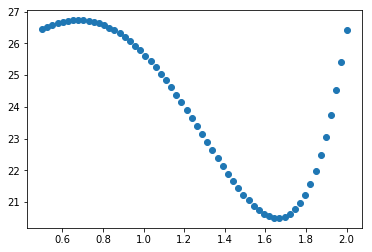

In [7]:
fig, ax = plt.subplots()
scales = np.linspace(0.5, 2, 60)



def total_volume(sheet):
    return sheet.face_df.vol.mean()

volumes =  np.array([
    scaled_unscaled(total_volume, s,
    sheet, geom,
    args=[sheet], kwargs={})
    for s in scales])

energies =  np.array([scaled_unscaled(
    model.compute_energy, s,
    sheet, geom,
    args=[sheet], kwargs={})
    for s in scales])

ax.plot(scales, energies, 'o')
#ax.set_yscale('log')


In [8]:
print(scales[np.argmin(energies)])

1.6186440678


In [8]:
E_t, E_c, E_v = model.compute_energy(sheet, full_output=True)

In [9]:
from scipy import optimize

def bruteforce_isotropic_relax(sheet, geom, model):
    def to_minimize(scale):
        return scaled_unscaled(model.compute_energy,
            scale, sheet,
            geom, args=[sheet])
    
    return optimize.minimize_scalar(to_minimize, bracket=[1., 3.])

In [10]:
res = bruteforce_isotropic_relax(sheet, geom, model)
geom.scale(sheet, res['x'], sheet.coords)
geom.update_all(sheet)


In [11]:
model.compute_gradient(sheet)

,x,y,z
srce,,,
0,-0.037981,0.053060,0.023924
1,-0.071332,0.019645,-0.004533
2,-0.093876,-0.030113,0.008156
3,-0.047103,0.004582,-0.004718
4,-0.043446,-0.015541,-0.003246
5,-0.033524,-0.037944,-0.007568
6,-0.052769,-0.062113,-0.007508
7,-0.039432,0.021842,0.002949
8,-0.039786,0.016451,-0.001397


In [12]:
res = Solver.find_energy_min(sheet, geom, model)

In [13]:
res['success']

True

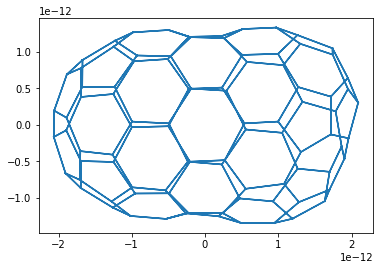

In [15]:
from tyssue.draw.plt_draw import plot_forces
fig, ax = plot_forces(sheet, geom, model, list('zx'), scaling=5)

In [18]:
sheet.settings

{'ab': [1.8376085083736911, 1.2639630010227065],
 'geometry': 'rod',
 'grad_norm_factor': 1.0,
 'height_axis': 'z',
 'nrj_norm_factor': 1.0}

(0, 2.0)

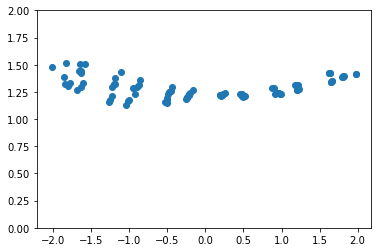

In [19]:
fig, ax = plt.subplots()
ax.plot(sheet.vert_df.z, sheet.vert_df.rho, 'o')
ax.set_ylim(0, 2.)

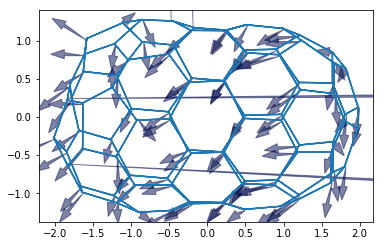

In [21]:
fig, ax = plot_forces(sheet, geom, model, list('zx'),
                      scaling=5, approx_grad=Solver.approx_grad)